In [1]:
%load_ext autoreload

In [2]:
# imports
%aimport sym
%autoreload 1
import os
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
plt.style.use('dark_background')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
data_train = torchvision.datasets.CIFAR10("./data/", train=True,transform=torchvision.transforms.ToTensor())  
data_val = torchvision.datasets.CIFAR10("./data/", train=False,transform=torchvision.transforms.ToTensor())  

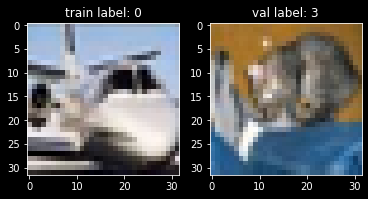

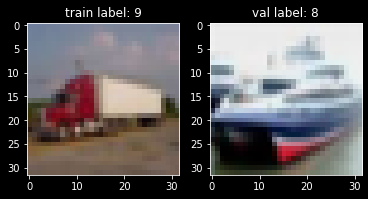

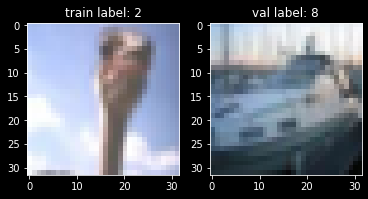

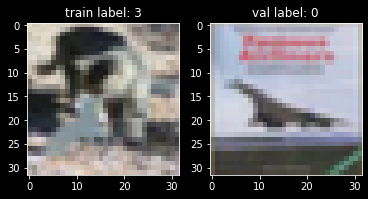

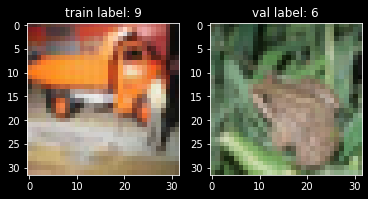

In [4]:
#Data Loaders
trainloader =torch.utils.data.DataLoader(data_train,num_workers=6,
                                          batch_size=16,
                                          shuffle=True)
valloader =torch.utils.data.DataLoader(data_val,num_workers=6,
                                          batch_size=16,
                                          shuffle=False)
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x.permute(1,2,0))
    axes[1].imshow(x2.permute(1,2,0))
    if i==5: break

In [27]:
%autoreload

In [28]:
logdir = "./lightning_logs/CIFAR"
if not os.path.exists(logdir): os.mkdir(logdir)
epochs = 10

In [31]:
# Train the CNN 
nfilters = [256,256,256]
stride=1
kernel_size = 5
hidden = 1024
module = sym.models.CNN(3, out_channels=10, h=32, w=32, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,
    optim=torch.optim.Adam(module.parameters(),lr=1e-3,weight_decay=1e-2),
)

In [32]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"/CNN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 108 M 


Epoch 9: 100%|##########| 3750/3750 [01:41<00:00, 37.03it/s, loss=0.008, v_num=11, val_loss=0.0494, val_acc=0.682]


1

In [161]:
filters_ = list(cnn.model.conv_blocks.parameters())[0].cpu().squeeze().detach().numpy()
biases = list(cnn.model.conv_blocks.parameters())[1].cpu().detach().numpy()

In [169]:
def norm(x):
    return (x-x.min())/(x.max()-x.min())
filters_= norm(filters_)
filters = filters_.transpose(0,2,3,1)

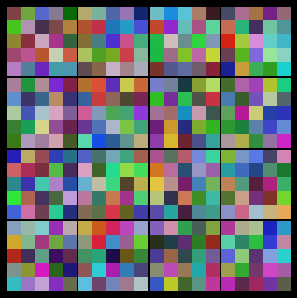

In [170]:
fig,axes = plt.subplots(4,4,figsize=(4,4))
for filt,ax in zip(filters[:16],axes.flatten()):
    ax.imshow(filt)
    ax.axis("off")
fig.tight_layout(pad=0.2)

In [171]:
mu = filters.reshape(-1,filters[0].size).mean(axis=0)
x_bar = filters.reshape(-1,filters[0].size) - mu 
cov_filters = np.array([np.matmul(x.reshape(-1,1),x.reshape(1,-1)) for x in x_bar]).mean(axis=0)

In [172]:
eigvalues, eigvectors = np.linalg.eig(cov_filters)

In [175]:
eigvectors.shape

(75, 75)

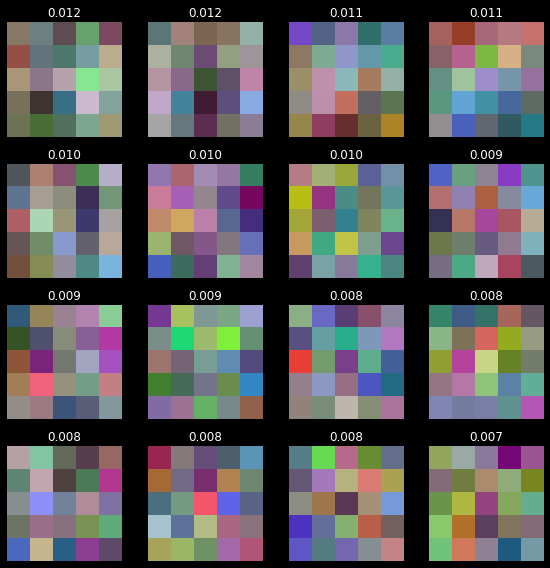

In [168]:
eigenfilters = norm(eigvectors.T)
fig,axes = plt.subplots(4,4,figsize=(8,8))
for i,ax in enumerate(axes.flatten()):
    ax.imshow(eigenfilters[i].reshape(filters[0].shape))
    ax.axis("off")
    ax.set_title(f"{eigvalues[i]:.3f}")
fig.tight_layout()

# 63% run

In [7]:
# Train the CNN 
nfilters = 1024
stride=3
kernel_size = 3
hidden = 1024
module = sym.models.CNN(3, out_channels=10, h=32, w=32, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,
    optim=torch.optim.Adam(module.parameters(),lr=1e-4),
)

In [8]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"/CNN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 104 M 


Epoch 9: 100%|##########| 3750/3750 [01:14<00:00, 50.08it/s, loss=0.022, v_num=9, val_loss=0.0517, val_acc=0.627]


1

In [34]:
# Define training and validation functions
def batch(x,y):
    x = x.to(device)
    y = y.to(device)
    y = torch.nn.functional.one_hot(y, 10).float()
    return x,y
def train(model, x, y):
    x,y = batch(x,y)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x,y = batch(x,y)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
    return loss.item()
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        losses_train.append(loss)
        loss = np.mean(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return np.concatenate(losses_train), losses_val
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        targets = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
            targets.append(y.cpu().numpy())
    yhat = np.concatenate(yhat).argmax(1)
    targets = np.concatenate(targets).reshape(-1)
    out = classification_report(yhat.astype(int),targets.astype(int))
    print(out)
    return 
def plot_loss(losses_train,losses_val,smoothing=None):
    if smoothing is None: 
        y = losses_train.reshape(-1,T).mean(axis=0)
    else:
        y = np.convolve(np.ones(smoothing)/smoothing,losses_train)
    plt.plot(np.linspace(0,T,len(y)),
             y, label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [7]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps
lr = 1e-4
criterion = torch.nn.MSELoss()

In [9]:
# Train the CNN 
nfilters = 1024
stride=3
kernel_size = 5
hidden = 1024
lr=1e-5
cnn = sym.models.CNN(3, out_channels=10, h=32, w=32, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=torch.nn.Softmax(1))
cnn.to(device)
cnn.optimizer = torch.optim.Adam(cnn.parameters(),lr=lr)
losses_train_cnn, losses_val_cnn = train_loop(cnn,T=T,log_step=log_step)

Epoch 001/30  | Training loss: 0.0735 - Validation loss: 0.0680
Epoch 002/30  | Training loss: 0.0654 - Validation loss: 0.0640
Epoch 003/30  | Training loss: 0.0611 - Validation loss: 0.0611
Epoch 004/30  | Training loss: 0.0579 - Validation loss: 0.0596
Epoch 005/30  | Training loss: 0.0553 - Validation loss: 0.0574
Epoch 006/30  | Training loss: 0.0531 - Validation loss: 0.0567
Epoch 007/30  | Training loss: 0.0510 - Validation loss: 0.0553
Epoch 008/30  | Training loss: 0.0493 - Validation loss: 0.0549
Epoch 009/30  | Training loss: 0.0476 - Validation loss: 0.0535
Epoch 010/30  | Training loss: 0.0460 - Validation loss: 0.0540
Epoch 011/30  | Training loss: 0.0445 - Validation loss: 0.0534
Epoch 012/30  | Training loss: 0.0432 - Validation loss: 0.0520
Epoch 013/30  | Training loss: 0.0418 - Validation loss: 0.0515
Epoch 014/30  | Training loss: 0.0404 - Validation loss: 0.0512
Epoch 015/30  | Training loss: 0.0391 - Validation loss: 0.0509
Epoch 016/30  | Training loss: 0.0379 - 

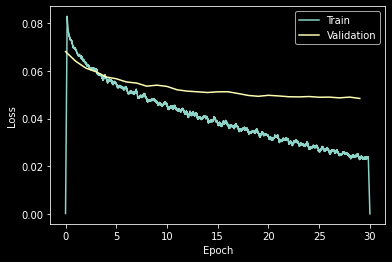

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1045
           1       0.76      0.75      0.75      1015
           2       0.50      0.54      0.52       934
           3       0.39      0.50      0.44       784
           4       0.60      0.56      0.58      1060
           5       0.55      0.56      0.55       985
           6       0.77      0.67      0.71      1146
           7       0.74      0.68      0.71      1091
           8       0.71      0.81      0.76       884
           9       0.72      0.68      0.70      1056

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.65      0.64      0.65     10000



In [10]:
plot_loss(losses_train_cnn, losses_val_cnn,smoothing=500)
metrics(cnn)

In [ ]:
x = torch.rand(4,10)
#y = torch.randint(0,10,(4,))
y = x.argmax(dim=1)
y = torch.nn.functional.one_hot(y, 10)

print(y)
print(torch.nn.Softmax(1)(x))
criterion(x,y)